## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [29]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
df = pd.read_parquet('/content/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


I cleaned the data by eliminating common words like "and" or "the," punctuation, and numbers. Then, I converted the remaining words into a one-hot encoded format to create features representing each email.

For prediction, I would split the data into training and testing sets, then use algorithms like logistic regression, support vector machines, or decision trees to classify emails as phishing or not. If the assignment focuses on PCA and linear models, I would apply PCA for dimensionality reduction to retain only the most significant features, then use a linear model like logistic regression for classification.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

<Axes: >

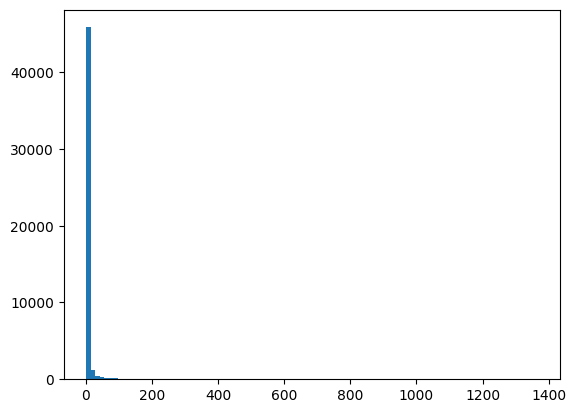

In [6]:
with open('/content/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

In [7]:
gdf['count'].describe()

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


The majority of tokens occur only once, with only a small number appearing more than 10 times. At the 75th percentile, tokens appear just twice, while the most frequent token shows up 1,365 times. This poses challenges: infrequent tokens are unlikely to provide meaningful insights, and overly common words, such as "the" or "and," lack the specificity needed to distinguish scam emails.

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [21]:
#1
df = pd.read_parquet('/content/Phishing_Email.parquet')

y = df['Email Type']
X = df['Email Text']


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=125)

#2
lm_0 = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_hat_train_0 = lm_0.predict(X_train)
y_hat_test_0 = lm_0.predict(X_test)


print('Train R2: ', r2_score(y_train, y_hat_train_0))
print('Test R2: ', r2_score(y_test, y_hat_test_0))

Train R2:  0.6737970402098046
Test R2:  0.656227932715151


In [26]:
#3
feature_names = tfidf.get_feature_names_out()

rdf = pd.DataFrame({
    'word': feature_names,
    'coefficient': lm_0.coef_
})

rdf['abs_coefficient'] = rdf['coefficient'].abs()


rdf_sorted = rdf.sort_values('abs_coefficient', ascending=False)
print(rdf_sorted.head(10))
print(rdf_sorted.tail(10))

           word  coefficient  abs_coefficient
250    listinfo     1.282788         1.282788
220  investment    -1.246855         1.246855
122        date     1.106900         1.106900
399  statements    -0.952192         0.952192
422      thanks     0.910404         0.910404
492       wrote     0.793018         0.793018
189       group     0.697053         0.697053
150       enron     0.696418         0.696418
121        data     0.683031         0.683031
97           cc    -0.661465         0.661465
           word  coefficient  abs_coefficient
6           100    -0.006312         0.006312
293         not    -0.005979         0.005979
124         day     0.005537         0.005537
345         put     0.004927         0.004927
294        note    -0.004277         0.004277
185        good     0.002686         0.002686
113     content    -0.002412         0.002412
199         his    -0.000699         0.000699
156  experience     0.000412         0.000412
416  technology    -0.000197      

The words with the largest absolute coefficients, such as "listinfo" (1.282788) and "investment" (-1.246855), are the most influential. For example, "listinfo" strongly increases the likelihood of predicting one class (e.g., non-phishing), while "investment" strongly decreases it. These words are likely key indicators of their respective classes.

On the other hand, words with small absolute coefficients, like "technology" (-0.000197) and "experience" (0.000412), have minimal impact on the predictions. These words are not strong predictors and likely do not contribute much to the model's decision-making process.

Overall, the coefficients highlight which words the model considers most important in distinguishing between classes, helping us understand how specific tokens influence its predictions.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

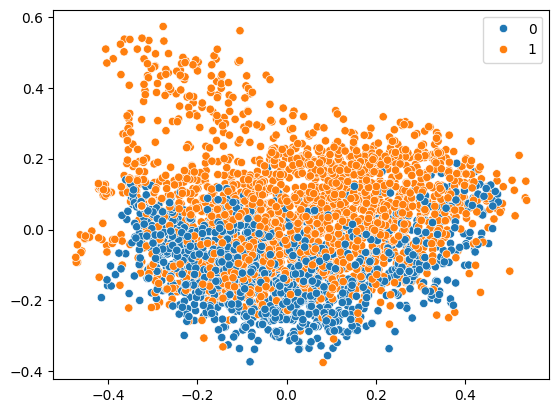

In [27]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

Orange seems to be scams. Will need to separate them

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [30]:
n_components = 100
reduction = PCA(n_components=n_components).fit(X_train)

Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train, y_train)

y_hat_train = lm_k.predict(Z_train)
y_hat_test = lm_k.predict(Z_test)

print('Train R2: ', r2_score(y_train, y_hat_train))
print('Test R2: ', r2_score(y_test, y_hat_test))


Train R2:  0.6869698343858268
Test R2:  0.6784539215650862


This is good because the test is similar to the train

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

It reduced multicollinearity. However, we still cannot decipher what the components are.